In [1]:
import obspy
import os
import pickle
import datetime
import time

# Location
pi = 3.1415926
degree2km = pi*6371/180
center = (-91.133, -0.815) # centre of caldera 
horizontal_degree = 0.5
vertical_degree = 0.5
zero_anchor = (center[0]-horizontal_degree, center[1]-vertical_degree)

# Time
starttime = obspy.UTCDateTime("2018-06-04T00:00:00")
endtime = obspy.UTCDateTime("2018-06-05T00:00:00")

# seismic stations
network_list = "8G"
# channel_list = "HNE,HNN,HNZ,HHE,HHN,HHZ,BHE,BHN,BHZ,EHE,EHN,EHZ"
channel_list = "HHE,HHN,HHZ"

config_file = "config.pkl"
datetime_file = "datetimes.pkl"
station_file = "stations.pkl"
data_path = "./mseed/"
station_list = "stations.csv"
fname_list = "mseed.csv"
if not os.path.exists(data_path):
    os.mkdir(data_path)
####### save config ########
config = {}
config["center"] = center
config["horizontal_degree"] = horizontal_degree
config["vertical_degree"] = vertical_degree
config["zero_anchor"] = zero_anchor
config["xlim"] = [0, horizontal_degree*2*degree2km]
config["ylim"] = [0, vertical_degree*2*degree2km]
config["anchor"] = zero_anchor
config["degree2km"] = degree2km
config["starttime"] = starttime
config["endtime"] = endtime
config["networks"] = network_list
config["channels"] = channel_list
config["network_list"] = network_list
config["channel_list"] = channel_list
with open(config_file, "wb") as fp:
    pickle.dump(config, fp)

one_day = datetime.timedelta(days=1)
one_hour = datetime.timedelta(hours=1)
one_minute = datetime.timedelta(minutes=1)
invertal = 1*one_day
starttimes = []
tmp_start = starttime
while tmp_start < endtime:
    starttimes.append(tmp_start)
    tmp_start += invertal

with open(datetime_file, "wb") as fp:
    pickle.dump({"starttimes": starttimes, "interval": invertal}, fp)

print(starttimes)

[UTCDateTime(2018, 6, 4, 0, 0)]


Number of stations: 10


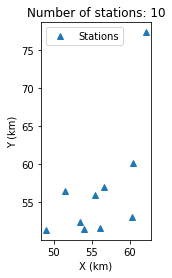

In [2]:
from obspy.clients.fdsn import Client
import matplotlib
# matplotlib.use("agg")
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

with open(config_file, "rb") as fp:
    config = pickle.load(fp)

####### Download stations ########
stations = Client("IRIS").get_stations(network = config["network_list"],
                                       station = "*",
                                       starttime=config["starttime"],
                                       endtime=config["endtime"],
                                       minlatitude=config["center"][1]-config["vertical_degree"],
                                       maxlatitude=config["center"][1]+config["vertical_degree"],
                                       minlongitude=config["center"][0]-config["horizontal_degree"],
                                       maxlongitude=config["center"][0]+config["horizontal_degree"],
                                       channel=config["channel_list"],
                                       level="response",
                                       filename=os.path.join(data_path, 'stations.xml'))

stations = obspy.read_inventory(os.path.join(data_path, 'stations.xml'))
print("Number of stations: {}".format(sum([len(x) for x in stations])))
# stations.plot('local', outfile="stations.png")

####### Save stations ########
station_locs = defaultdict(dict)
for network in stations:
    for station in network:
        for chn in station:
            x = (chn.longitude - config["zero_anchor"][0])*config["degree2km"]
            y = (chn.latitude - config["zero_anchor"][1])*config["degree2km"]
            z = -chn.elevation / 1e3 #km
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["x(km)"], tmp_dict["y(km)"], tmp_dict["z(km)"] = x, y, z
                tmp_dict["lng"], tmp_dict["lat"], tmp_dict["elv(m)"] = chn.longitude, chn.latitude, chn.elevation
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict
station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
station_locs.to_csv(station_list,
                    sep="\t", float_format="%.3f",
                    index_label="station",
                    columns=["x(km)", "y(km)", "z(km)", "lat", "lng", "elv(m)", "unit", "component", "response"])

#     ####### Plot stations ########
plt.figure()
plt.plot(station_locs["x(km)"], station_locs["y(km)"], "^", label="Stations")
#     plt.plot(catalog["x(km)"], catalog["y(km)"], "k.", label="Earthquakes")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.axis("scaled")
plt.legend()
plt.title(f"Number of stations: {len(station_locs)}")
#     plt.savefig(os.path.join(data_path, "stations_events.png"))
plt.show()

with open(station_file, "wb") as fp:
    pickle.dump(stations, fp)

In [3]:
with open(config_file, "rb") as fp:
    config = pickle.load(fp)
with open(datetime_file, "rb") as fp:
    tmp = pickle.load(fp)
    starttimes = tmp["starttimes"]
    interval = tmp["interval"]
with open(station_file, "rb") as fp:
    stations = pickle.load(fp)

waveform_dir = os.path.join(data_path, "waveforms")
sac_dir = os.path.join(data_path, "sac")
if not os.path.exists(waveform_dir):
    os.mkdir(waveform_dir)
if not os.path.exists(sac_dir):
    os.mkdir(sac_dir)
####### Download data ########
client = Client("IRIS")
fname_sac = open("sac.csv", "w")
fname_sac.write("fname\tE\tN\tZ\n")
fp = open(fname_list, "w")
fp.write("fname\n")
# for i in idx: 
for i in range(len(starttimes)):
    starttime = starttimes[i] 
    endtime = starttime + interval
    fname = "{}.mseed".format(starttime.datetime.strftime("%Y-%m-%dT%H:%M"))

    max_retry = 3
    stream = obspy.Stream()
    print(f"{fname} download starts")
    for network in stations:
        for station in network:
            print("***", station.code, "***")
            retry = 0
            while retry < max_retry:
                try:
                    tmp = client.get_waveforms(network.code, station.code, "*", config["channel_list"], starttime, endtime, attach_response=True)
                    print("Read in waveform")
                    tmp.remove_sensitivity()
                    print("Removed instrument response")
                    tmp.write(os.path.join(waveform_dir, f"{network.code}.{station.code}.{fname}"))
                    print("Written miniseed file")
                    line = f"{network.code}.{station.code}.{fname.rstrip('.mseed')}"
                    for c in config["channel_list"].split(","):
                        x = tmp.select(channel=c)
                        x.write(os.path.join(sac_dir, f"{network.code}.{station.code}.{fname.rstrip('.mseed')}.{c}.sac"), format='SAC')
                        line += f"\t{network.code}.{station.code}.{fname.rstrip('.mseed')}.{c}.sac"
                        print("Written sac file")
                    line += "\n"
                    fname_sac.write(line)
                    stream += tmp
                    break
                except Exception as e:
                    err = e
                    retry += 1
                    time.sleep(1)
                    continue
            if retry == max_retry:
                print(f"{fname}: MAX {max_retry} retries reached : {network.code}.{station.code} with error: {err}")
    if not os.path.exists(waveform_dir):
        os.makedirs(waveform_dir)
    stream.write(os.path.join(waveform_dir, fname))
    print(f"{fname} download succeeds")
    fp.write(f"{fname}\n")
    

fp.close()
fname_sac.close()
print(os.listdir(waveform_dir))

2018-06-04T00:00.mseed download starts
*** SN01 ***
2018-06-04T00:00.mseed: MAX 3 retries reached : 8G.SN01 with error: No data available for request.
HTTP Status code: 204
Detailed response of server:


*** SN03 ***
2018-06-04T00:00.mseed: MAX 3 retries reached : 8G.SN03 with error: No data available for request.
HTTP Status code: 204
Detailed response of server:


*** SN04 ***
Read in waveform
Removed instrument response


/opt/anaconda3/envs/phasenet/lib/python3.7/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Written miniseed file
Written sac file
Written sac file
Written sac file
*** SN05 ***
Read in waveform
Removed instrument response


/opt/anaconda3/envs/phasenet/lib/python3.7/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Written miniseed file
Written sac file
Written sac file
Written sac file
*** SN07 ***
Read in waveform
Removed instrument response


/opt/anaconda3/envs/phasenet/lib/python3.7/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Written miniseed file
Written sac file
Written sac file
Written sac file
*** SN08 ***
2018-06-04T00:00.mseed: MAX 3 retries reached : 8G.SN08 with error: No data available for request.
HTTP Status code: 204
Detailed response of server:


*** SN11 ***
Read in waveform
Removed instrument response


/opt/anaconda3/envs/phasenet/lib/python3.7/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Written miniseed file
Written sac file
Written sac file
Written sac file
*** SN12 ***
Read in waveform
Removed instrument response


/opt/anaconda3/envs/phasenet/lib/python3.7/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Written miniseed file
Written sac file
Written sac file
Written sac file
*** SN13 ***
Read in waveform
Removed instrument response


/opt/anaconda3/envs/phasenet/lib/python3.7/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Written miniseed file
Written sac file
Written sac file
Written sac file
*** SN14 ***
Read in waveform
Removed instrument response


/opt/anaconda3/envs/phasenet/lib/python3.7/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Written miniseed file
Written sac file
Written sac file
Written sac file


/opt/anaconda3/envs/phasenet/lib/python3.7/site-packages/obspy/io/mseed/core.py:825: UserWarning: File will be written with more than one different byteorders.
This might have a negative influence on the compatibility with other programs.
  warnings.warn(msg % 'byteorders')


2018-06-04T00:00.mseed download succeeds
['8G.SN11.2018-06-04T00:00.mseed', '8G.SN13.2018-06-04T00:00.mseed', '8G.SN04.2018-06-04T00:00.mseed', '8G.SN07.2018-06-04T00:00.mseed', '8G.SN05.2018-06-04T00:00.mseed', '2018-06-04T00:00.mseed', '8G.SN12.2018-06-04T00:00.mseed', '8G.SN14.2018-06-04T00:00.mseed']


In [5]:
pwd

'/Volumes/sbutcher/ML in Seismology/PhaseNet_Tutorial/PhaseNet/demo'

In [6]:
!echo "fname" > mseed_station.csv && cd mseed/waveforms && ls 8G* >> ../mseed_station.csv

In [7]:
!echo "fname" > mseed.csv && cd mseed/waveforms && ls 2018* >> ../mseed.csv

In [1]:
!cat mseed/mseed_station.csv

fname
8G.SN04.2018-06-04T00:00.mseed
8G.SN05.2018-06-04T00:00.mseed
8G.SN07.2018-06-04T00:00.mseed
8G.SN11.2018-06-04T00:00.mseed
8G.SN12.2018-06-04T00:00.mseed
8G.SN13.2018-06-04T00:00.mseed
8G.SN14.2018-06-04T00:00.mseed


In [2]:
!cat mseed/mseed.csv

fname
2018-06-04T00:00.mseed


In [10]:
!rm stations.xml stations.pkl datetimes.pkl config.pkl

rm: stations.xml: No such file or directory
